# Spaceship Titanic - V5 (V2 + Regularized Target Encoding)

**History:**
- V1: CV 0.8265 / LB 0.8020 (49 features, overfit)
- V2: CV 0.8141 / LB 0.8071 (29 features, best LB)
- V3: CV 0.8184 / LB 0.8041 (56 features, TE on interactions = overfit)
- V4: CV 0.8146 / LB TBD (33 features, V2+simple EDA)

**V5 Strategy:** V2 base (29 features) + ONLY target encoding on 3 low-cardinality categoricals:
- HomePlanet (3 cats), Destination (3 cats), Deck (8 cats)

**Why V3 TE failed:**
- Encoded HIGH-cardinality interactions (DeckSide: 16 cats, PlanetDeck: 24 cats)
- Small samples per category → noisy means → overfit
- 56 total features = too much noise

**V5 TE safeguards:**
1. 10-fold OOF (matching main CV) instead of V3's 5-fold
2. Bayesian smoothing: blend cat_mean with global_mean weighted by sample size
3. Only 3 low-cardinality columns → stable means (min ~300 samples per cat)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import warnings, os

warnings.filterwarnings('ignore')

SEED = 42
N_FOLDS = 10
TARGET = 'Transported'

def seed_everything(seed=SEED):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything()
print('V5 Setup complete.')

V5 Setup complete.


In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample_sub = pd.read_csv('../data/sample_submission.csv')

print(f'Train: {train.shape}, Test: {test.shape}')

train['is_train'] = 1
test['is_train'] = 0
test[TARGET] = np.nan
df = pd.concat([train, test], axis=0, ignore_index=True)

spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
print(f'Combined: {df.shape}')

Train: (8693, 14), Test: (4277, 13)
Combined: (12970, 15)


## Feature Engineering V5 = V2 Base (identical)

In [3]:
# === V2 Feature Engineering (IDENTICAL copy) ===

# PassengerId
df['_Group'] = df['PassengerId'].str.split('_').str[0].astype(int)
df['GroupSize'] = df.groupby('_Group')['PassengerId'].transform('count')
df['IsAlone'] = (df['GroupSize'] == 1).astype(int)

# Cabin
df['Deck'] = df['Cabin'].str.split('/').str[0]
df['CabinNum'] = df['Cabin'].str.split('/').str[1].astype(float)
df['Side'] = df['Cabin'].str.split('/').str[2]
df['CabinRegion'] = (df['CabinNum'] // 100).astype(float)

# Name
df['Surname'] = df['Name'].str.split().str[-1]
df['FamilySize'] = df.groupby('Surname')['PassengerId'].transform('count')
df.loc[df['Surname'].isna(), 'FamilySize'] = 1

# Booleans
df['CryoSleep'] = df['CryoSleep'].map({True: 1, False: 0, 'True': 1, 'False': 0})
df['VIP'] = df['VIP'].map({True: 1, False: 0, 'True': 1, 'False': 0})

print('Parsing done.')

Parsing done.


In [4]:
# === V2 Imputation (identical) ===
for col in spend_cols:
    mask = (df['CryoSleep'] == 1) & (df[col].isna())
    df.loc[mask, col] = 0

mask = (df['CryoSleep'].isna()) & (df[spend_cols].sum(axis=1) == 0)
df.loc[mask, 'CryoSleep'] = 1
mask = (df['CryoSleep'].isna()) & (df[spend_cols].sum(axis=1) > 0)
df.loc[mask, 'CryoSleep'] = 0

for col in df.select_dtypes(include=[np.number]).columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())

for col in df.select_dtypes(include=['object']).columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0])

print(f'Imputation done. Nulls: {df.isnull().sum().sum()}')

Imputation done. Nulls: 0


In [5]:
# === V2 Spending features (identical) ===
df['TotalSpend'] = df[spend_cols].sum(axis=1)
df['TotalSpend_log'] = np.log1p(df['TotalSpend'])
df['NoSpend'] = (df['TotalSpend'] == 0).astype(int)
df['NumServicesUsed'] = (df[spend_cols] > 0).sum(axis=1)

for col in spend_cols:
    df[f'{col}_log'] = np.log1p(df[col])

df['LuxurySpend'] = np.log1p(df['Spa'] + df['VRDeck'] + df['RoomService'])
df['BasicSpend'] = np.log1p(df['FoodCourt'] + df['ShoppingMall'])

# Age
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 5, 12, 18, 30, 50, 80],
                        labels=[0, 1, 2, 3, 4, 5]).astype(float)
df['IsChild'] = (df['Age'] < 18).astype(float)

# Interactions
df['CryoSleep_NoSpend'] = ((df['CryoSleep'] == 1) & (df['TotalSpend'] == 0)).astype(int)

# Group spending
df['GroupSpend_mean'] = df.groupby('_Group')['TotalSpend'].transform('mean')
df['GroupSpend_mean_log'] = np.log1p(df['GroupSpend_mean'])

# Label encoding
for col in ['HomePlanet', 'Destination', 'Deck', 'Side']:
    le = LabelEncoder()
    df[col + '_le'] = le.fit_transform(df[col].astype(str))

# Frequency encoding
for col in ['HomePlanet', 'Destination', 'Deck', 'Side']:
    freq = df[col].value_counts(normalize=True)
    df[col + '_freq'] = df[col].map(freq)

print('V2 features done.')

V2 features done.


## V5 Addition: Regularized Target Encoding

**Bayesian smoothed target encoding** on 3 low-cardinality features:
- HomePlanet (3 categories, min ~2000 samples each)
- Destination (3 categories, min ~1500 samples each)
- Deck (8 categories, min ~300 samples each)

Formula: `TE = (n * cat_mean + m * global_mean) / (n + m)`  
where `m` = smoothing factor (higher = more regularization)

In [6]:
# Check category sizes to confirm safety
print('Category sizes (train only):')
train_mask = df['is_train'] == 1
for col in ['HomePlanet', 'Destination', 'Deck']:
    print(f'\n{col}:')
    print(df.loc[train_mask, col].value_counts().sort_index())

Category sizes (train only):

HomePlanet:
HomePlanet
Earth     4803
Europa    2131
Mars      1759
Name: count, dtype: int64

Destination:
Destination
55 Cancri e      1800
PSO J318.5-22     796
TRAPPIST-1e      6097
Name: count, dtype: int64

Deck:
Deck
A     256
B     779
C     747
D     478
E     876
F    2993
G    2559
T       5
Name: count, dtype: int64


In [7]:
# === REGULARIZED TARGET ENCODING ===

te_cols = ['HomePlanet', 'Destination', 'Deck']
SMOOTHING = 20  # Bayesian smoothing factor

train_idx = df[df['is_train'] == 1].index
test_idx = df[df['is_train'] == 0].index

# Convert target for train rows
y_for_te = df.loc[train_idx, TARGET].map({True: 1.0, False: 0.0, 1: 1.0, 0: 0.0}).astype(float)
df.loc[train_idx, '_target_float'] = y_for_te.values
global_mean = float(y_for_te.mean())

print(f'Global mean: {global_mean:.4f}')
print(f'Smoothing factor: {SMOOTHING}')
print(f'TE folds: {N_FOLDS} (matching main CV)')

# 10-fold OOF target encoding with Bayesian smoothing
kf_te = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for col in te_cols:
    col_te = f'{col}_te'
    df[col_te] = global_mean  # safe initialization
    
    # OOF for train
    for fold_train, fold_val in kf_te.split(train_idx, y_for_te):
        fold_train_idx = train_idx[fold_train]
        fold_val_idx = train_idx[fold_val]
        
        # Compute stats on fold's training portion
        stats = df.loc[fold_train_idx].groupby(col)['_target_float'].agg(['mean', 'count'])
        
        # Bayesian smoothing: blend category mean with global mean
        stats['te'] = (stats['count'] * stats['mean'] + SMOOTHING * global_mean) / (stats['count'] + SMOOTHING)
        
        # Map to validation fold
        mapped = df.loc[fold_val_idx, col].map(stats['te']).fillna(global_mean)
        df.loc[fold_val_idx, col_te] = mapped.values
    
    # For test: use ALL train data with smoothing
    stats = df.loc[train_idx].groupby(col)['_target_float'].agg(['mean', 'count'])
    stats['te'] = (stats['count'] * stats['mean'] + SMOOTHING * global_mean) / (stats['count'] + SMOOTHING)
    mapped = df.loc[test_idx, col].map(stats['te']).fillna(global_mean)
    df.loc[test_idx, col_te] = mapped.values
    
    # Show the encoding values
    print(f'\n{col}_te values:')
    te_vals = df.loc[train_idx].groupby(col)[col_te].mean()
    print(te_vals.sort_values())

# Cleanup
df.drop('_target_float', axis=1, inplace=True)
print('\nTarget encoding done.')

Global mean: 0.5036
Smoothing factor: 20
TE folds: 10 (matching main CV)

HomePlanet_te values:
HomePlanet
Earth     0.427992
Mars      0.522746
Europa    0.657200
Name: HomePlanet_te, dtype: float64

Destination_te values:
Destination
TRAPPIST-1e      0.472316
PSO J318.5-22    0.503595
55 Cancri e      0.608844
Name: Destination_te, dtype: float64



Deck_te values:
Deck
E    0.360759
D    0.436514
F    0.444390
T    0.451985
A    0.496330
G    0.516114
C    0.674882
B    0.727923
Name: Deck_te, dtype: float64

Target encoding done.


In [8]:
# === DEFINE FEATURES: V2 base + 3 TE features ===
drop_cols = [
    'PassengerId', 'Name', 'Cabin', 'Surname', 'is_train', TARGET,
    'HomePlanet', 'Destination', 'Deck', 'Side',
    '_Group', 'CabinNum',
    'TotalSpend', 'GroupSpend_mean',
] + spend_cols

features = [c for c in df.columns if c not in drop_cols]
print(f'V5 features: {len(features)} (V2: 29 + 3 TE = 32)')
print()
for i, f in enumerate(sorted(features)):
    marker = ' *** NEW' if f.endswith('_te') else ''
    print(f'  {i+1:2d}. {f}{marker}')

V5 features: 32 (V2: 29 + 3 TE = 32)

   1. Age
   2. AgeGroup
   3. BasicSpend
   4. CabinRegion
   5. CryoSleep
   6. CryoSleep_NoSpend
   7. Deck_freq
   8. Deck_le
   9. Deck_te *** NEW
  10. Destination_freq
  11. Destination_le
  12. Destination_te *** NEW
  13. FamilySize
  14. FoodCourt_log
  15. GroupSize
  16. GroupSpend_mean_log
  17. HomePlanet_freq
  18. HomePlanet_le
  19. HomePlanet_te *** NEW
  20. IsAlone
  21. IsChild
  22. LuxurySpend
  23. NoSpend
  24. NumServicesUsed
  25. RoomService_log
  26. ShoppingMall_log
  27. Side_freq
  28. Side_le
  29. Spa_log
  30. TotalSpend_log
  31. VIP
  32. VRDeck_log


In [9]:
# Split
train_df = df[df['is_train'] == 1].copy()
test_df = df[df['is_train'] == 0].copy()

X = train_df[features].values
y = train_df[TARGET].astype(int).values
X_test = test_df[features].values

print(f'X: {X.shape}, y: {y.shape}, X_test: {X_test.shape}')
print(f'Target mean: {np.mean(y):.4f}')

X: (8693, 32), y: (8693,), X_test: (4277, 32)
Target mean: 0.5036


## LightGBM V5 (V2 regularization)

In [10]:
# V2 regularization params (identical)
lgb_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 20,
    'learning_rate': 0.03,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'min_child_samples': 30,
    'reg_alpha': 0.5,
    'reg_lambda': 2.0,
    'max_depth': 5,
    'n_estimators': 5000,
    'verbose': -1,
    'n_jobs': -1,
    'random_state': SEED,
}

oof_lgb = np.zeros(len(X))
test_lgb = np.zeros(len(X_test))
fi_lgb = np.zeros(len(features))

kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y)):
    X_tr, X_val = X[tr_idx], X[val_idx]
    y_tr, y_val = y[tr_idx], y[val_idx]
    
    model = lgb.LGBMClassifier(**lgb_params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(200), lgb.log_evaluation(500)]
    )
    
    oof_lgb[val_idx] = model.predict_proba(X_val)[:, 1]
    test_lgb += model.predict_proba(X_test)[:, 1] / N_FOLDS
    fi_lgb += model.feature_importances_ / N_FOLDS
    
    fold_acc = accuracy_score(y_val, (oof_lgb[val_idx] > 0.5).astype(int))
    print(f'Fold {fold+1}/{N_FOLDS} - Accuracy: {fold_acc:.5f}')

lgb_acc = accuracy_score(y, (oof_lgb > 0.5).astype(int))
print(f'\nLightGBM V5 CV: {lgb_acc:.5f}')

Training until validation scores don't improve for 200 rounds

[500]	valid_0's binary_logloss: 0.393696

Early stopping, best iteration is:
[627]	valid_0's binary_logloss: 0.39281
Fold 1/10 - Accuracy: 0.80000
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.362724
Early stopping, best iteration is:
[519]	valid_0's binary_logloss: 0.362139
Fold 2/10 - Accuracy: 0.82069
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.360507


Early stopping, best iteration is:
[649]	valid_0's binary_logloss: 0.359005
Fold 3/10 - Accuracy: 0.82414
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.424173


Early stopping, best iteration is:
[611]	valid_0's binary_logloss: 0.422521
Fold 4/10 - Accuracy: 0.78481
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.358111


Early stopping, best iteration is:
[437]	valid_0's binary_logloss: 0.357145
Fold 5/10 - Accuracy: 0.83084
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.376178


Early stopping, best iteration is:
[703]	valid_0's binary_logloss: 0.372315
Fold 6/10 - Accuracy: 0.83084
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.36112


Early stopping, best iteration is:
[379]	valid_0's binary_logloss: 0.358442
Fold 7/10 - Accuracy: 0.83429
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.368711


Early stopping, best iteration is:
[460]	valid_0's binary_logloss: 0.368221
Fold 8/10 - Accuracy: 0.82509
Training until validation scores don't improve for 200 rounds


Early stopping, best iteration is:
[261]	valid_0's binary_logloss: 0.390075
Fold 9/10 - Accuracy: 0.79402
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.398166


Early stopping, best iteration is:
[516]	valid_0's binary_logloss: 0.397616
Fold 10/10 - Accuracy: 0.80092

LightGBM V5 CV: 0.81456


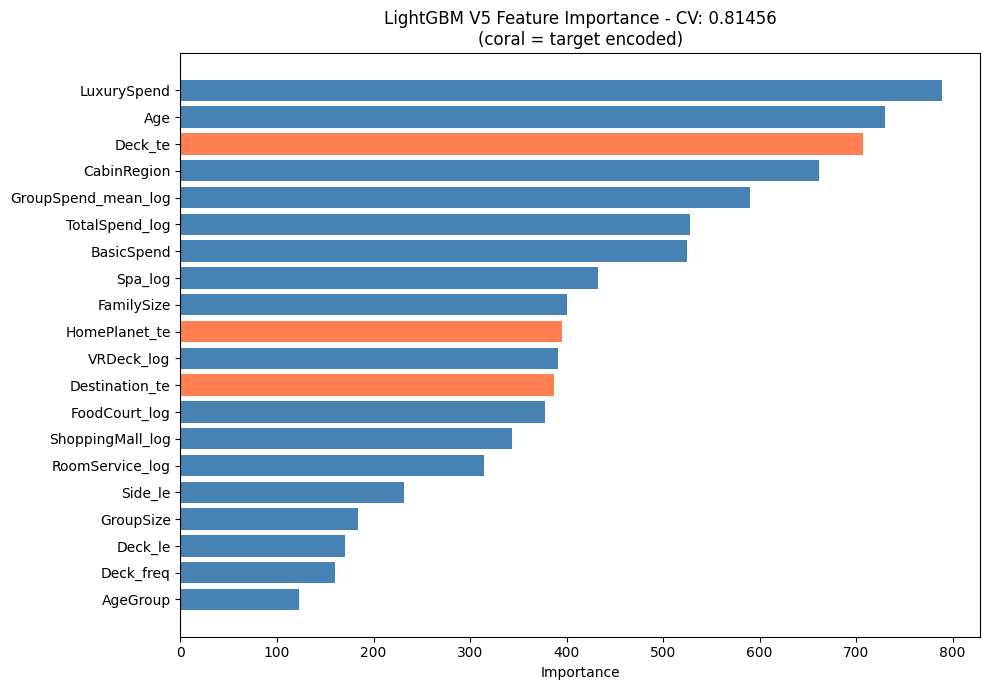


TE features ranking:
  Deck_te: importance=706.7
  HomePlanet_te: importance=395.7
  Destination_te: importance=387.4


In [11]:
# Feature importance - check if TE features are useful
fi_df = pd.DataFrame({'feature': features, 'importance': fi_lgb})
fi_df = fi_df.sort_values('importance', ascending=True).tail(20)

plt.figure(figsize=(10, 7))
colors = ['coral' if f.endswith('_te') else 'steelblue' for f in fi_df['feature']]
plt.barh(fi_df['feature'], fi_df['importance'], color=colors)
plt.title(f'LightGBM V5 Feature Importance - CV: {lgb_acc:.5f}\n(coral = target encoded)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# TE features ranking
fi_all = pd.DataFrame({'feature': features, 'importance': fi_lgb}).sort_values('importance', ascending=False)
print('\nTE features ranking:')
for _, row in fi_all.iterrows():
    if row['feature'].endswith('_te'):
        rank = fi_all.index.get_loc(_) + 1 if hasattr(fi_all.index, 'get_loc') else 0
        print(f"  {row['feature']}: importance={row['importance']:.1f}")

## XGBoost V5 (V2 regularization)

In [12]:
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 4,
    'learning_rate': 0.03,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 10,
    'reg_alpha': 0.5,
    'reg_lambda': 2.0,
    'gamma': 0.1,
    'n_estimators': 5000,
    'early_stopping_rounds': 200,
    'tree_method': 'hist',
    'random_state': SEED,
    'verbosity': 0,
}

oof_xgb = np.zeros(len(X))
test_xgb = np.zeros(len(X_test))

for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y)):
    X_tr, X_val = X[tr_idx], X[val_idx]
    y_tr, y_val = y[tr_idx], y[val_idx]
    
    model = xgb.XGBClassifier(**xgb_params)
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=500)
    
    oof_xgb[val_idx] = model.predict_proba(X_val)[:, 1]
    test_xgb += model.predict_proba(X_test)[:, 1] / N_FOLDS
    
    fold_acc = accuracy_score(y_val, (oof_xgb[val_idx] > 0.5).astype(int))
    print(f'Fold {fold+1}/{N_FOLDS} - Accuracy: {fold_acc:.5f}')

xgb_acc = accuracy_score(y, (oof_xgb > 0.5).astype(int))
print(f'\nXGBoost V5 CV: {xgb_acc:.5f}')

[0]	validation_0-logloss:0.68043


[500]	validation_0-logloss:0.40126


[941]	validation_0-logloss:0.40049


Fold 1/10 - Accuracy: 0.80000
[0]	validation_0-logloss:0.68002


[500]	validation_0-logloss:0.36458


[603]	validation_0-logloss:0.36457


Fold 2/10 - Accuracy: 0.82759
[0]	validation_0-logloss:0.67988


[500]	validation_0-logloss:0.36230


[676]	validation_0-logloss:0.36211


Fold 3/10 - Accuracy: 0.81954
[0]	validation_0-logloss:0.68219


[500]	validation_0-logloss:0.42250


[1000]	validation_0-logloss:0.41930


[1282]	validation_0-logloss:0.42032


Fold 4/10 - Accuracy: 0.78826
[0]	validation_0-logloss:0.68049


[500]	validation_0-logloss:0.36449


[1000]	validation_0-logloss:0.35943

[1217]	validation_0-logloss:0.35974


Fold 5/10 - Accuracy: 0.82969
[0]	validation_0-logloss:0.68124


[500]	validation_0-logloss:0.38524


[1000]	validation_0-logloss:0.37747


[1280]	validation_0-logloss:0.37759


Fold 6/10 - Accuracy: 0.82048
[0]	validation_0-logloss:0.68048


[500]	validation_0-logloss:0.35696


[793]	validation_0-logloss:0.35721


Fold 7/10 - Accuracy: 0.83084
[0]	validation_0-logloss:0.68052


[500]	validation_0-logloss:0.37340

[1000]	validation_0-logloss:0.36876


[1241]	validation_0-logloss:0.36914


Fold 8/10 - Accuracy: 0.81818
[0]	validation_0-logloss:0.68037


[500]	validation_0-logloss:0.39373

[650]	validation_0-logloss:0.39387


Fold 9/10 - Accuracy: 0.80207
[0]	validation_0-logloss:0.68147


[500]	validation_0-logloss:0.40391


[727]	validation_0-logloss:0.40616


Fold 10/10 - Accuracy: 0.80092

XGBoost V5 CV: 0.81376


## CatBoost V5 (V2 regularization)

In [13]:
oof_cb = np.zeros(len(X))
test_cb = np.zeros(len(X_test))

for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y)):
    X_tr, X_val = X[tr_idx], X[val_idx]
    y_tr, y_val = y[tr_idx], y[val_idx]
    
    model = CatBoostClassifier(
        iterations=5000,
        learning_rate=0.03,
        depth=4,
        l2_leaf_reg=5.0,
        subsample=0.7,
        colsample_bylevel=0.7,
        min_data_in_leaf=30,
        random_seed=SEED,
        verbose=500,
        early_stopping_rounds=200,
        task_type='CPU',
    )
    
    model.fit(X_tr, y_tr, eval_set=(X_val, y_val))
    
    oof_cb[val_idx] = model.predict_proba(X_val)[:, 1]
    test_cb += model.predict_proba(X_test)[:, 1] / N_FOLDS
    
    fold_acc = accuracy_score(y_val, (oof_cb[val_idx] > 0.5).astype(int))
    print(f'Fold {fold+1}/{N_FOLDS} - Accuracy: {fold_acc:.5f}')

cb_acc = accuracy_score(y, (oof_cb > 0.5).astype(int))
print(f'\nCatBoost V5 CV: {cb_acc:.5f}')

0:	learn: 0.6780717	test: 0.6772151	best: 0.6772151 (0)	total: 150ms	remaining: 12m 27s


500:	learn: 0.3513258	test: 0.3934450	best: 0.3934288 (496)	total: 949ms	remaining: 8.52s


1000:	learn: 0.3129635	test: 0.3877892	best: 0.3877892 (1000)	total: 1.7s	remaining: 6.81s


1500:	learn: 0.2865357	test: 0.3857177	best: 0.3856544 (1453)	total: 2.47s	remaining: 5.75s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3854266435
bestIteration = 1647

Shrink model to first 1648 iterations.
Fold 1/10 - Accuracy: 0.81034
0:	learn: 0.6782683	test: 0.6777079	best: 0.6777079 (0)	total: 1.45ms	remaining: 7.27s


500:	learn: 0.3548286	test: 0.3619610	best: 0.3619610 (500)	total: 762ms	remaining: 6.84s


1000:	learn: 0.3149453	test: 0.3548622	best: 0.3547745 (973)	total: 1.53s	remaining: 6.12s


1500:	learn: 0.2874655	test: 0.3533773	best: 0.3530967 (1470)	total: 2.29s	remaining: 5.33s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3530966899
bestIteration = 1470

Shrink model to first 1471 iterations.
Fold 2/10 - Accuracy: 0.83448
0:	learn: 0.6782570	test: 0.6774409	best: 0.6774409 (0)	total: 1.58ms	remaining: 7.9s


500:	learn: 0.3557544	test: 0.3606588	best: 0.3606588 (500)	total: 760ms	remaining: 6.82s


1000:	learn: 0.3166610	test: 0.3569749	best: 0.3569317 (999)	total: 1.75s	remaining: 6.98s


1500:	learn: 0.2877187	test: 0.3556239	best: 0.3553215 (1367)	total: 3.34s	remaining: 7.78s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3550227322
bestIteration = 1536

Shrink model to first 1537 iterations.
Fold 3/10 - Accuracy: 0.82759
0:	learn: 0.6776627	test: 0.6794072	best: 0.6794072 (0)	total: 12.7ms	remaining: 1m 3s


500:	learn: 0.3499673	test: 0.4245364	best: 0.4245364 (500)	total: 1.61s	remaining: 14.5s


1000:	learn: 0.3113180	test: 0.4175507	best: 0.4175507 (1000)	total: 3.21s	remaining: 12.8s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4164248014
bestIteration = 1184

Shrink model to first 1185 iterations.
Fold 4/10 - Accuracy: 0.78596
0:	learn: 0.6783595	test: 0.6780064	best: 0.6780064 (0)	total: 3.3ms	remaining: 16.5s


500:	learn: 0.3548343	test: 0.3628108	best: 0.3627987 (498)	total: 1.59s	remaining: 14.3s


1000:	learn: 0.3155961	test: 0.3575333	best: 0.3573480 (991)	total: 3.15s	remaining: 12.6s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3558745122
bestIteration = 1276

Shrink model to first 1277 iterations.
Fold 5/10 - Accuracy: 0.83429
0:	learn: 0.6779075	test: 0.6788150	best: 0.6788150 (0)	total: 3.41ms	remaining: 17s


500:	learn: 0.3524277	test: 0.3913420	best: 0.3913420 (500)	total: 1.5s	remaining: 13.5s


1000:	learn: 0.3147590	test: 0.3828008	best: 0.3828008 (1000)	total: 3.18s	remaining: 12.7s


1500:	learn: 0.2862161	test: 0.3787151	best: 0.3787050 (1499)	total: 4.8s	remaining: 11.2s


2000:	learn: 0.2644404	test: 0.3760718	best: 0.3759079 (1984)	total: 6.5s	remaining: 9.74s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3757539044
bestIteration = 2017

Shrink model to first 2018 iterations.
Fold 6/10 - Accuracy: 0.82163
0:	learn: 0.6782074	test: 0.6780829	best: 0.6780829 (0)	total: 7.57ms	remaining: 37.8s


500:	learn: 0.3569198	test: 0.3597149	best: 0.3597149 (500)	total: 1.63s	remaining: 14.7s


1000:	learn: 0.3168058	test: 0.3528200	best: 0.3525934 (981)	total: 3.21s	remaining: 12.8s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.351409142
bestIteration = 1259

Shrink model to first 1260 iterations.
Fold 7/10 - Accuracy: 0.83429
0:	learn: 0.6781181	test: 0.6783715	best: 0.6783715 (0)	total: 4.2ms	remaining: 21s


500:	learn: 0.3540969	test: 0.3743746	best: 0.3743396 (499)	total: 874ms	remaining: 7.84s


1000:	learn: 0.3160366	test: 0.3676478	best: 0.3675270 (995)	total: 1.65s	remaining: 6.58s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3666570772
bestIteration = 1107

Shrink model to first 1108 iterations.
Fold 8/10 - Accuracy: 0.81358
0:	learn: 0.6783198	test: 0.6778370	best: 0.6778370 (0)	total: 3.11ms	remaining: 15.6s


500:	learn: 0.3522520	test: 0.3920946	best: 0.3920246 (499)	total: 762ms	remaining: 6.84s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3901427759
bestIteration = 714

Shrink model to first 715 iterations.
Fold 9/10 - Accuracy: 0.80783
0:	learn: 0.6779987	test: 0.6786302	best: 0.6786302 (0)	total: 1.79ms	remaining: 8.94s


500:	learn: 0.3515156	test: 0.4067202	best: 0.4064453 (484)	total: 785ms	remaining: 7.05s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4026184468
bestIteration = 729

Shrink model to first 730 iterations.
Fold 10/10 - Accuracy: 0.79747

CatBoost V5 CV: 0.81675


## Ensemble & Submission

In [14]:
print('=== V5 Results ===')
print(f'LightGBM: {lgb_acc:.5f}')
print(f'XGBoost:  {xgb_acc:.5f}')
print(f'CatBoost: {cb_acc:.5f}')

# Simple average
oof_avg = (oof_lgb + oof_xgb + oof_cb) / 3
avg_acc = accuracy_score(y, (oof_avg > 0.5).astype(int))
print(f'\nSimple Average: {avg_acc:.5f}')

# Majority voting
votes = ((oof_lgb > 0.5).astype(int) + (oof_xgb > 0.5).astype(int) + (oof_cb > 0.5).astype(int))
vote_acc = accuracy_score(y, (votes >= 2).astype(int))
print(f'Majority Voting: {vote_acc:.5f}')

# Submission
final_proba = (test_lgb + test_xgb + test_cb) / 3
final_preds = (final_proba > 0.5)

print(f'\nTest: {final_preds.sum()} True / {len(final_preds) - final_preds.sum()} False')
print(f'Ratio: {final_preds.mean():.4f}')

print(f'\n=== VERSION COMPARISON ===')
print(f'V1: CV 0.82653 | LB 0.80196 | Gap 0.0246 | 49 features')
print(f'V2: CV 0.81410 | LB 0.80710 | Gap 0.0070 | 29 features')
print(f'V3: CV 0.81836 | LB 0.80406 | Gap 0.0143 | 56 features (TE on interactions)')
print(f'V4: CV 0.81456 | LB TBD     |            | 33 features')
print(f'V5: CV {avg_acc:.5f} | LB TBD     |            | {len(features)} features (TE low-card only)')

=== V5 Results ===
LightGBM: 0.81456
XGBoost:  0.81376
CatBoost: 0.81675

Simple Average: 0.81767
Majority Voting: 0.81721

Test: 2212 True / 2065 False
Ratio: 0.5172

=== VERSION COMPARISON ===
V1: CV 0.82653 | LB 0.80196 | Gap 0.0246 | 49 features
V2: CV 0.81410 | LB 0.80710 | Gap 0.0070 | 29 features
V3: CV 0.81836 | LB 0.80406 | Gap 0.0143 | 56 features (TE on interactions)
V4: CV 0.81456 | LB TBD     |            | 33 features
V5: CV 0.81767 | LB TBD     |            | 32 features (TE low-card only)


In [15]:
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'].values,
    'Transported': final_preds
})
submission['Transported'] = submission['Transported'].astype(bool)
submission.to_csv('../submissions/submission_v5.csv', index=False)

assert submission.shape[0] == sample_sub.shape[0]
assert list(submission.columns) == list(sample_sub.columns)
assert submission['Transported'].dtype == bool

print('V5 Submission saved: submissions/submission_v5.csv')
print(submission['Transported'].value_counts(normalize=True))
submission.head()

V5 Submission saved: submissions/submission_v5.csv
Transported
True     0.517185
False    0.482815
Name: proportion, dtype: float64


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
